<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/008_TensorFlow_Proj_Eight_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Univariate Forcasting Prices

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import warnings, os, sys, warnings
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.config import list_physical_devices, experimental
from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
physical_devices = list_physical_devices("GPU")
experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
print("tensorflow:", tf.__version__)

tensorflow: 2.13.0


In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
url = "https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/yfinance.csv"
stocks = pd.read_csv(url, index_col=0, header=[0,1])
stocks.head()

Adj Close                                                 \
                 AAPL         GLD       MSFT         QQQ         SPY   
Date                                                                   
2018-01-02  40.950497  125.150002  80.940392  153.123489  246.766678   
2018-01-03  40.943367  124.820000  81.317093  154.611298  248.327499   
2018-01-04  41.133541  125.459999  82.032768  154.881836  249.374115   
2018-01-05  41.601864  125.330002  83.049835  156.437332  251.035934   
2018-01-08  41.447350  125.309998  83.134598  157.045990  251.495041   

                                      Close                         ...  \
                 TSLA        USO       AAPL         GLD       MSFT  ...   
Date                                                                ...   
2018-01-02  21.368668  96.559998  43.064999  125.150002  85.949997  ...   
2018-01-03  21.150000  98.720001  43.057499  124.820000  86.349998  ...   
2018-01-04  20.974667  98.959999  43.257500  125.459999  87.110001  ...   
2018-01-05  21.105333  98.480003  43.750000  125.330002  88.190002  ...   
2018-01-08  22.427334  99.040001  43.587502  125.309998  88.279999  ...   

                  Open                           Volume                      \
                   SPY       TSLA        USO       AAPL       GLD      MSFT   
Date                                                                          
2018-01-02  267.839996  20.799999  96.559998  102223600  11762500  22483800   
2018-01-03  268.959991  21.400000  97.360001  118071600   7904300  26061400   
2018-01-04  271.200012  20.858000  98.639999   89738400   7329700  21912000   
2018-01-05  272.510010  21.108000  98.239998   94640000   5739900  23407100   
2018-01-08  273.309998  21.066668  98.480003   82271200   3566700  22113000   

                                                    
                 QQQ       SPY       TSLA      USO  
Date                                                
2018-01-02  32573300  86655700   65283000  1497588  
2018-01-03  29383600  90070400   67822500  2156150  
2018-01-04  24776100  80636400  149194500  1480988  
2018-01-05  26992300  83524000   68868000  1609888  
2018-01-08  23159100  57319200  147891000  1229225  

[5 rows x 42 columns]

In [ ]:
stocks.index = pd.to_datetime(stocks.index).to_period('B')
stocks.index

PeriodIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
             '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
             '2018-01-12', '2018-01-16',
             ...
             '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
             '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
             '2022-12-29', '2022-12-30'],
            dtype='period[B]', name='Date', length=1259)

In [ ]:
_df = stocks["Close"][["AAPL"]]
_df.head()

,AAPL
Date,
2018-01-02,43.064999
2018-01-03,43.057499
2018-01-04,43.257500
2018-01-05,43.750000
2018-01-08,43.587502


In [ ]:
assert _df.index.is_monotonic_increasing

In [ ]:
idx = pd.period_range(min(_df.index), max(_df.index))
df = _df.reindex(idx, fill_value=np.nan)
df = df.fillna(method = 'ffill')
df.tail(5)

,AAPL
2022-12-26,131.860001
2022-12-27,130.029999
2022-12-28,126.040001
2022-12-29,129.610001
2022-12-30,129.929993


<Axes: >

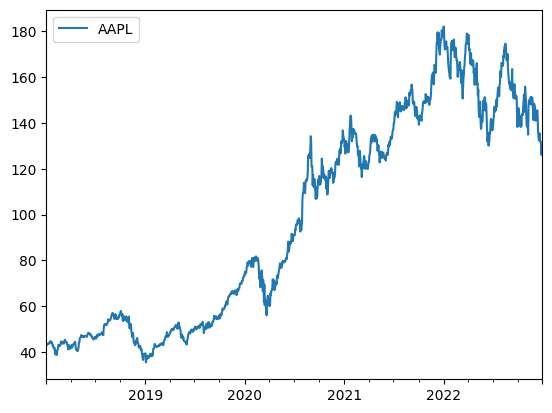

In [ ]:
df.plot()

In [ ]:
df['Log_AAPL']= np.log(df['AAPL'])
df = df[304:]
df.head()

,AAPL,Log_AAPL
2019-03-04,43.962502,3.783337
2019-03-05,43.882500,3.781516
2019-03-06,43.630001,3.775745
2019-03-07,43.125000,3.764103
2019-03-08,43.227501,3.766477


<Axes: >

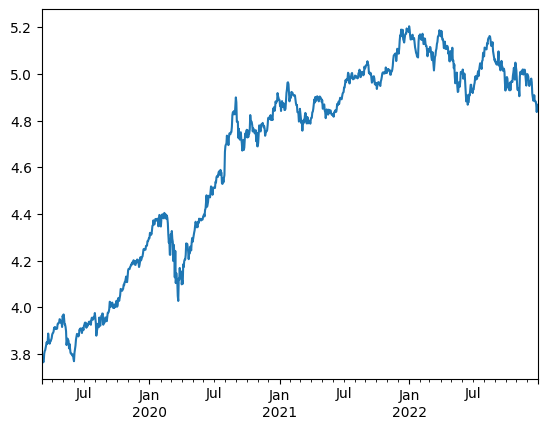

In [ ]:
df["Log_AAPL"].plot()

In [ ]:
test_period = 100
train_period = len(df) - test_period
train_set = df.iloc[:train_period]
test_set  = df.iloc[train_period:]
train_indicator = (df.index <= train_set.index[-1])
test_indicator =  (df.index > train_set.index[-1])
log_aapl = df['Log_AAPL'].dropna().to_numpy()
delta_x, delta_y = 100, 1
X = np.array(
    [log_aapl[t:t+delta_x] for t in range(len(log_aapl) - delta_x - delta_y + 1)]
).reshape(-1, delta_x, 1)
Y = np.array(
    [log_aapl[t+delta_x+delta_y-1] for t in range(len(log_aapl) - delta_x - delta_y + 1)]
).reshape(-1, delta_y)
print("X:", X.shape, "Y:", Y.shape)
X_train, y_train = X[:-test_period], Y[:-test_period]
X_test, y_test = X[-test_period:], Y[-test_period:]

X: (900, 100, 1) Y: (900, 1)


In [ ]:
n_features = 1
inputs = tf.keras.Input(shape=(delta_x, n_features))
features = tf.keras.layers.LSTM(units=16)(inputs)
outputs = tf.keras.layers.Dense(1)(features)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
monitor = model.fit(X_train, y_train, epochs=100, validation_split=0.3)

Epoch 1/100
18/18 [==============================] - 8s 167ms/step - loss: 15.4552 - mae: 3.9147 - val_loss: 17.4914 - val_mae: 4.1814
Epoch 2/100
18/18 [==============================] - 1s 81ms/step - loss: 12.3829 - mae: 3.5008 - val_loss: 14.7126 - val_mae: 3.8348
Epoch 3/100
18/18 [==============================] - 1s 81ms/step - loss: 10.1573 - mae: 3.1663 - val_loss: 12.4080 - val_mae: 3.5215
Epoch 4/100
18/18 [==============================] - 2s 91ms/step - loss: 8.1816 - mae: 2.8349 - val_loss: 10.0163 - val_mae: 3.1637
Epoch 5/100
18/18 [==============================] - 2s 98ms/step - loss: 5.9906 - mae: 2.4154 - val_loss: 7.2620 - val_mae: 2.6934
Epoch 6/100
18/18 [==============================] - 1s 79ms/step - loss: 3.7627 - mae: 1.8972 - val_loss: 4.6163 - val_mae: 2.1467
Epoch 7/100
18/18 [==============================] - 1s 79ms/step - loss: 2.0098 - mae: 1.3639 - val_loss: 2.6692 - val_mae: 1.6314
Epoch 8/100
18/18 [==============================] - 2s 90ms/step - 

In [ ]:
train_predictions = model.predict(X_train).flatten()
test_predictions = model.predict(X_test).flatten()
test_predictions

4/4 [==============================] - 0s 13ms/step


array([4.963854 , 4.9690356, 4.973332 , 4.977932 , 4.981594 , 4.983333 ,
       4.982824 , 4.9825563, 4.982557 , 4.9839554, 4.981193 , 4.9779644,
       4.973866 , 4.969434 , 4.966153 , 4.9617996, 4.95813  , 4.954054 ,
       4.951495 , 4.9481106, 4.9471464, 4.9498653, 4.9455237, 4.9435062,
       4.9397326, 4.9355307, 4.934572 , 4.934978 , 4.932948 , 4.930771 ,
       4.9273977, 4.924892 , 4.923355 , 4.920561 , 4.912936 , 4.903655 ,
       4.8991866, 4.8975334, 4.8958626, 4.8936005, 4.887642 , 4.883169 ,
       4.8781047, 4.8732443, 4.872666 , 4.8680935, 4.867633 , 4.867941 ,
       4.8681526, 4.867978 , 4.8708344, 4.8746367, 4.879857 , 4.882043 ,
       4.880852 , 4.8881526, 4.8919735, 4.893525 , 4.8910565, 4.8847103,
       4.8793306, 4.8750653, 4.871652 , 4.8647823, 4.8685846, 4.872932 ,
       4.875348 , 4.878882 , 4.880969 , 4.8843193, 4.8875284, 4.887923 ,
       4.8901334, 4.8925495, 4.894568 , 4.894205 , 4.8912773, 4.886756 ,
       4.8882284, 4.8890862, 4.889364 , 4.8887815, 

In [ ]:
train_indicator[:delta_x] = False
df.loc[train_indicator, 'one_step_train'] =  train_predictions
df.loc[test_indicator, 'one_step_test'] =  test_predictions

<Axes: >

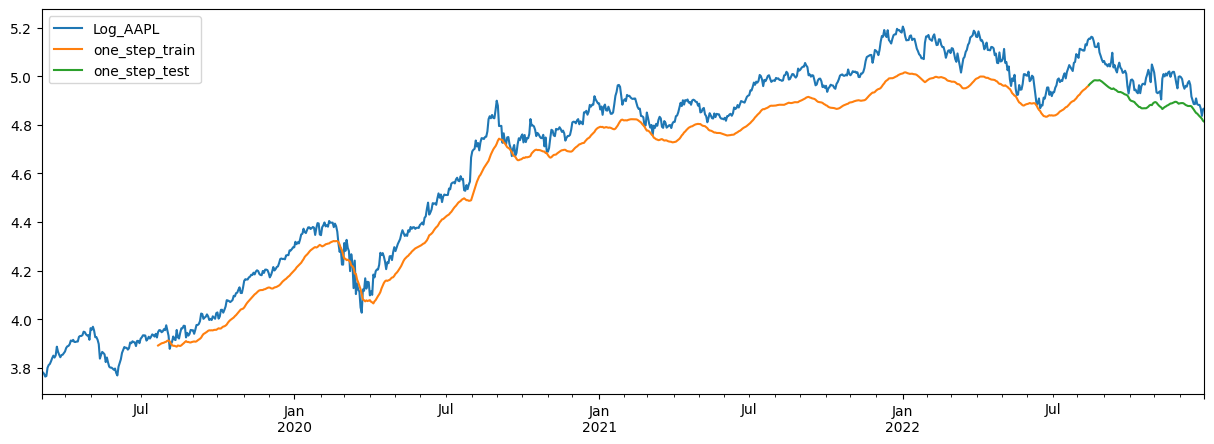

In [ ]:
df[['Log_AAPL', 'one_step_train', 'one_step_test']].plot(figsize=(15, 5))

In [ ]:
multistep_predictions = []
X_final = X_test[0]
while len(multistep_predictions) < test_period:
  pred = model.predict(X_final.reshape(1, -1, 1))[0]
  multistep_predictions.append(pred)
  X_final = np.roll(X_final, -1)
  X_final[-1] = pred

1/1 [==============================] - 0s 25ms/step


In [ ]:
df.loc[test_indicator, 'multistep_test'] = multistep_predictions

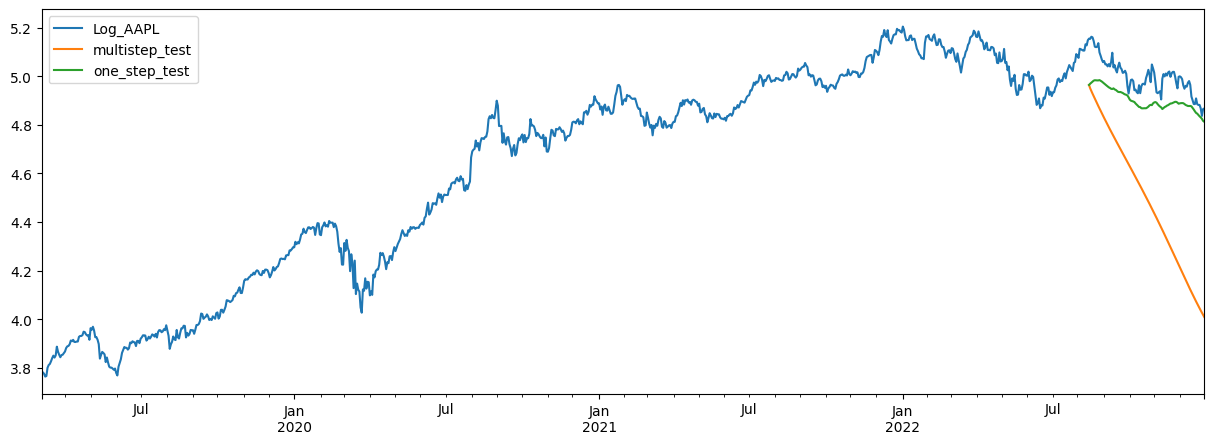

In [ ]:
df[['Log_AAPL', 'multistep_test', 'one_step_test']].plot(figsize=(15, 5));

In [ ]:
delta_x, delta_y = 100, 100
X = np.array(
    [log_aapl[t:t+delta_x] for t in range(len(log_aapl) - delta_x - delta_y + 1)]
).reshape(-1, delta_x, 1)
Y = np.array(
    [log_aapl[t+delta_x:t+delta_x+delta_y] for t in range(len(log_aapl) - delta_x - delta_y + 1)]
).reshape(-1, delta_y)
print("X:", X.shape, "Y:", Y.shape)
X_train_multi_out, y_train_multi_out = X[:-1], Y[:-1]
X_test_multi_out, y_test_multi_out = X[-1:], Y[-1:]

X: (801, 100, 1) Y: (801, 100)


In [ ]:
tf.keras.backend.clear_session()
n_features = 1
inputs = tf.keras.Input(shape=(delta_x, n_features), name="input_layer")
feat = tf.keras.layers.LSTM(16 , return_sequences=False, name="lstm_layer")(inputs)
# or
# feat = layers.LSTM(16 , return_sequences=True, name="lstm_layer")(inputs)
# feat = layers.GlobalMaxPooling1D(, name="pooling_layer")(feat)
outputs = tf.keras.layers.Dense(delta_y, name="dense_layer")(feat)
model = tf.keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
monitor = model.fit(X_train_multi_out, y_train_multi_out, epochs=100, validation_split=0.2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100, 1)]          0         
                                                                 
 lstm_layer (LSTM)           (None, 16)                1152      
                                                                 
 dense_layer (Dense)         (None, 100)               1700      
                                                                 
Total params: 2852 (11.14 KB)
Trainable params: 2852 (11.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
20/20 [==============================] - 3s 57ms/step - loss: 20.7236 - mae: 4.5318 - val_loss: 22.1516 - val_mae: 4.6956
Epoch 2/100
20/20 [==============================] - 1s 28ms/step - loss: 17.8300 - mae: 4.1931 - val_loss: 18.8535 - val_mae: 4.3238
Epoch 3/100
20/20 [====

<Axes: >

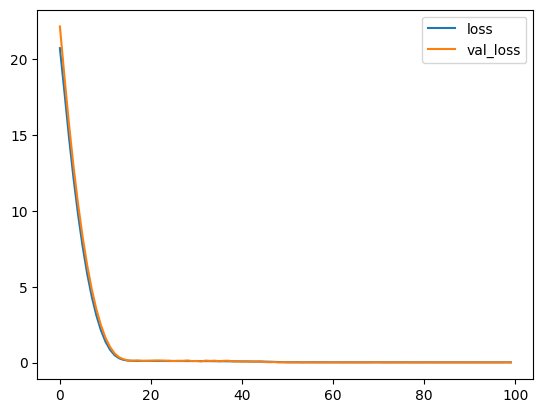

In [ ]:
metrics = pd.DataFrame(monitor.history)
metrics[['loss', 'val_loss']].plot()

In [ ]:
train_pred = model.predict(X_train_multi_out)[:,0]
test_pred = model.predict(X_test_multi_out)[0]

1/1 [==============================] - 0s 443ms/step


In [ ]:
df.loc[test_indicator, 'multioutput_test'] = test_pred

<Axes: >

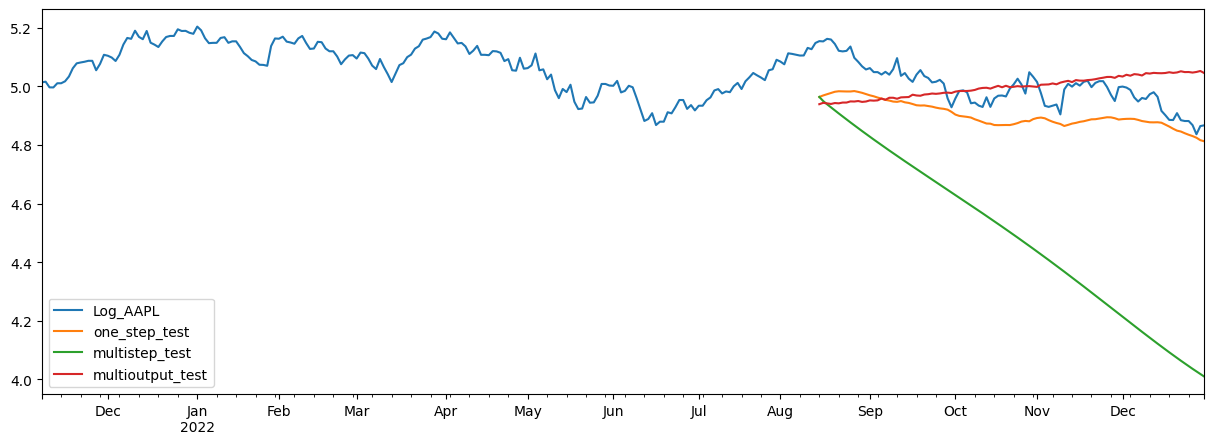

In [ ]:
cols = ['Log_AAPL', 'one_step_test', 'multistep_test',  'multioutput_test']
df.iloc[-300:][cols].plot(figsize=(15, 5))

In [ ]:
test_log_price = df.iloc[-test_period:]['Log_AAPL']
mae1 = mean_absolute_error(test_log_price, df.loc[test_indicator, 'one_step_test'])
mae2 = mean_absolute_error(test_log_price, df.loc[test_indicator, 'multistep_test'])
mae3 = mean_absolute_error(test_log_price, df.loc[test_indicator, 'multioutput_test'])
print("one-step_test MAE:", mae1)
print("multi-step MAE:", mae2)
print("multi-output MAE:", mae3)

one-step_test MAE: 0.09388588215147468
multi-step MAE: 0.5092721488598487
multi-output MAE: 0.0796230097731109


### Univariate Forcasting Returns

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
idx = pd.period_range(min(_df.index), max(_df.index))
dataframe = _df.reindex(idx, fill_value=np.nan)
dataframe.fillna(method = 'ffill', inplace=True)
dataframe.tail(10)

,AAPL
2022-12-19,132.369995
2022-12-20,132.300003
2022-12-21,135.449997
2022-12-22,132.229996
2022-12-23,131.860001
2022-12-26,131.860001
2022-12-27,130.029999
2022-12-28,126.040001
2022-12-29,129.610001
2022-12-30,129.929993


In [ ]:
dataframe["Log_AAPL"] = np.log(dataframe["AAPL"])
dataframe["Diff_Log_AAPL"] = dataframe["Log_AAPL"].diff(1)

<Axes: >

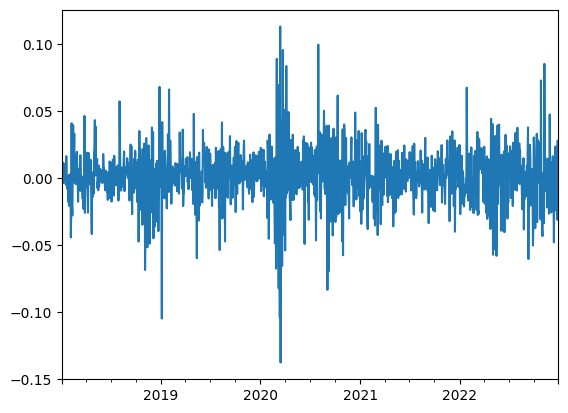

In [ ]:
dataframe["Diff_Log_AAPL"].plot()

In [ ]:
dataframe["Diff_Log_AAPL"].describe()

count    1303.000000
mean        0.000847
std         0.020745
min        -0.137708
25%        -0.008499
50%         0.000303
75%         0.011899
max         0.113157
Name: Diff_Log_AAPL, dtype: float64

In [ ]:
raw_frame = dataframe.copy()

In [ ]:
num_train_samples = int(0.6 * len(dataframe))
num_val_samples = int(0.2 * len(dataframe))
num_test_samples = len(dataframe) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 782
num_val_samples: 260
num_test_samples: 262


In [ ]:
series = dataframe['Diff_Log_AAPL'].dropna().to_numpy()
sequence_length = 60 # using the past 60 days to predict next day.
no_steps_ahead = 1
delay = sequence_length  + no_steps_ahead - 1
batch_size = 32
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
for samples, targets in train_dataset.take(1):
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)

samples shape: (32, 60)
targets shape: (32,)


In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [ ]:
print("Validation MAE: {:.3f}".format(evaluate_naive_method(val_dataset)))
print("Test MAE: {:.3f}".format(evaluate_naive_method(test_dataset)))

Validation MAE: 0.015
Test MAE: 0.026


In [ ]:
test_performance = {}

In [ ]:
test_performance['Baseline'] = evaluate_naive_method(test_dataset)

In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, n_features), name="input_layer")
features = tf.keras.layers.SimpleRNN(16, name="rnn_layer")(inputs)
outputs = tf.keras.layers.Dense(1, name="dense_layer")(features)
model = tf.keras.Model(inputs, outputs, name="simple_rnn_model")
model.summary()
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
monitor= model.fit(train_dataset, epochs=20, validation_data=val_dataset)
print("Test MAE: {:.5f}".format(model.evaluate(test_dataset)[1]))

Model: "simple_rnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 60, 1)]           0         
                                                                 
 rnn_layer (SimpleRNN)       (None, 16)                288       
                                                                 
 dense_layer (Dense)         (None, 1)                 17        
                                                                 
Total params: 305 (1.19 KB)
Trainable params: 305 (1.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
23/23 [==============================] - 2s 29ms/step - loss: 0.0032 - mae: 0.0400 - val_loss: 7.1349e-04 - val_mae: 0.0213
Epoch 2/20
23/23 [==============================] - 0s 20ms/step - loss: 0.0018 - mae: 0.0290 - val_loss: 4.9875e-04 - val_mae: 0.0177
Epoch 3/20
23/

In [ ]:
test_performance['SimpleRNN'] = model.evaluate(test_dataset, verbose=0)[1]
test_performance

{'Baseline': 0.02571843123112198, 'SimpleRNN': 0.01760908216238022}

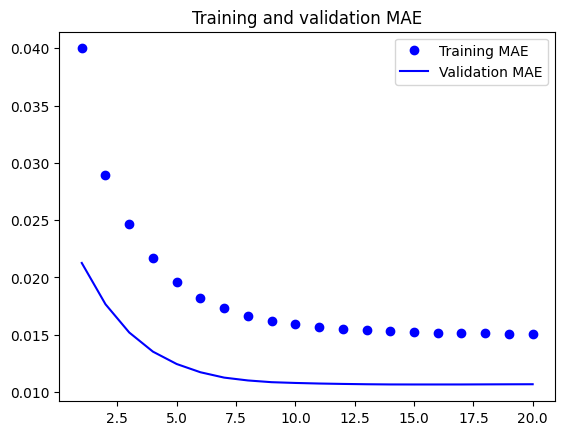

In [ ]:
loss = monitor.history["mae"]
val_loss = monitor.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, n_features), name="input_layer")
features = tf.keras.layers.LSTM(16, name="lstm_layer")(inputs)
outputs = tf.keras.layers.Dense(1, name="dense_layer")(features)
model = tf.keras.Model(inputs, outputs, name="lstm_model")
model.summary()
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
monitor= model.fit(train_dataset, epochs=20, validation_data=val_dataset)
print("Test MAE: {:.5f}".format(model.evaluate(test_dataset)[1]))

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 60, 1)]           0         
                                                                 
 lstm_layer (LSTM)           (None, 16)                1152      
                                                                 
 dense_layer (Dense)         (None, 1)                 17        
                                                                 
Total params: 1169 (4.57 KB)
Trainable params: 1169 (4.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
23/23 [==============================] - 3s 52ms/step - loss: 5.3019e-04 - mae: 0.0158 - val_loss: 1.8945e-04 - val_mae: 0.0107
Epoch 2/20
23/23 [==============================] - 1s 31ms/step - loss: 5.1044e-04 - mae: 0.0152 - val_loss: 1.8949e-04 - val_mae: 0.0107
Epoch 3/20

In [ ]:
test_performance['LSTM'] = model.evaluate(test_dataset, verbose=0)[1]
test_performance

{'Baseline': 0.02571843123112198,
 'SimpleRNN': 0.01760908216238022,
 'LSTM': 0.01756584644317627}

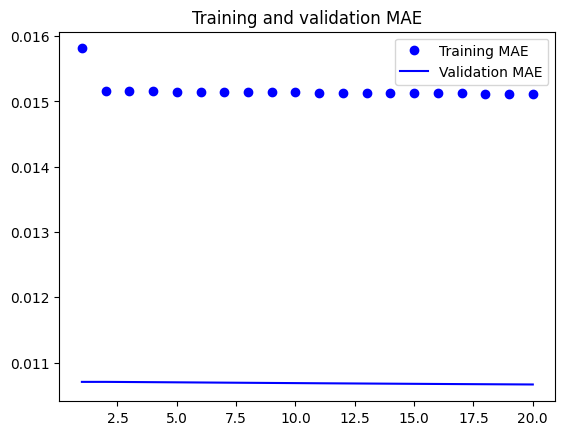

In [ ]:
loss = monitor.history["mae"]
val_loss = monitor.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Epoch 1/20
23/23 [==============================] - 9s 240ms/step - loss: 0.0613 - mae: 0.1911 - val_loss: 3.1605e-04 - val_mae: 0.0146
Epoch 2/20
23/23 [==============================] - 4s 158ms/step - loss: 0.0147 - mae: 0.0895 - val_loss: 2.3193e-04 - val_mae: 0.0122
Epoch 3/20
23/23 [==============================] - 4s 166ms/step - loss: 0.0015 - mae: 0.0297 - val_loss: 2.0815e-04 - val_mae: 0.0115
Epoch 4/20
23/23 [==============================] - 5s 214ms/step - loss: 9.0497e-04 - mae: 0.0224 - val_loss: 2.3244e-04 - val_mae: 0.0122
Epoch 5/20
23/23 [==============================] - 4s 167ms/step - loss: 8.2035e-04 - mae: 0.0207 - val_loss: 2.0178e-04 - val_mae: 0.0110
Epoch 6/20
23/23 [==============================] - 5s 213ms/step - loss: 7.2186e-04 - mae: 0.0196 - val_loss: 1.8505e-04 - val_mae: 0.0106
Epoch 7/20
23/23 [==============================] - 5s 211ms/step - loss: 6.7217e-04 - mae: 0.0191 - val_loss: 1.8345e-04 - val_mae: 0.0105
Epoch 8/20
23/23 [==============

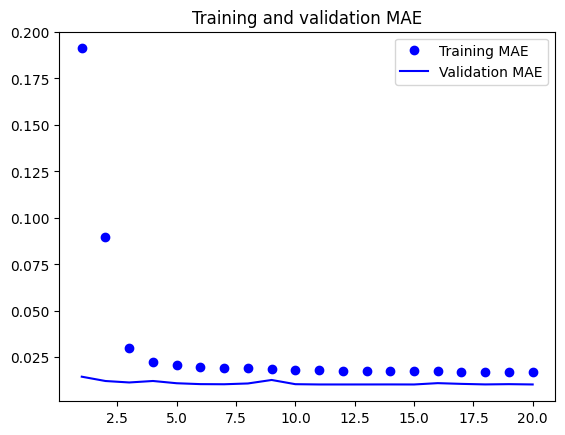

In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, n_features), name="input_layer")
feat = tf.keras.layers.LSTM(128, recurrent_dropout=0.1, return_sequences=True, name="lstm_layer")(inputs)
feat = tf.keras.layers.SimpleRNN(128, recurrent_dropout=0.1, name="rnn_layer")(feat)
feat = tf.keras.layers.Dropout(0.1, name="drop_out_layer")(feat)
outputs = tf.keras.layers.Dense(1, name="output_layer")(feat)
model = tf.keras.Model(inputs, outputs, name="lstm_with_recurrent_dropout")
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
monitor = model.fit(train_dataset, epochs=20, validation_data=val_dataset)
loss = monitor.history["mae"]
val_loss = monitor.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
print("Test MAE: {:.5f}".format(model.evaluate(test_dataset)[1]))

5/5 [==============================] - 0s 24ms/step - loss: 4.9285e-04 - mae: 0.0169
Test MAE: 0.01693


In [ ]:
test_performance['Stacked_RNN'] = model.evaluate(test_dataset, verbose=0)[1]
test_performance

{'Baseline': 0.02571843123112198,
 'SimpleRNN': 0.01760908216238022,
 'LSTM': 0.01756584644317627,
 'Stacked_RNN': 0.016931146383285522}

Epoch 1/20
23/23 [==============================] - 4s 60ms/step - loss: 0.0016 - mae: 0.0303 - val_loss: 3.0356e-04 - val_mae: 0.0138
Epoch 2/20
23/23 [==============================] - 1s 29ms/step - loss: 7.1402e-04 - mae: 0.0197 - val_loss: 2.4921e-04 - val_mae: 0.0124
Epoch 3/20
23/23 [==============================] - 1s 25ms/step - loss: 6.2449e-04 - mae: 0.0182 - val_loss: 2.2481e-04 - val_mae: 0.0117
Epoch 4/20
23/23 [==============================] - 1s 30ms/step - loss: 5.7578e-04 - mae: 0.0173 - val_loss: 2.1359e-04 - val_mae: 0.0115
Epoch 5/20
23/23 [==============================] - 1s 30ms/step - loss: 5.4827e-04 - mae: 0.0168 - val_loss: 2.0823e-04 - val_mae: 0.0113
Epoch 6/20
23/23 [==============================] - 1s 26ms/step - loss: 5.3173e-04 - mae: 0.0165 - val_loss: 2.0525e-04 - val_mae: 0.0113
Epoch 7/20
23/23 [==============================] - 1s 28ms/step - loss: 5.2049e-04 - mae: 0.0162 - val_loss: 2.0331e-04 - val_mae: 0.0112
Epoch 8/20
23/23 [=============

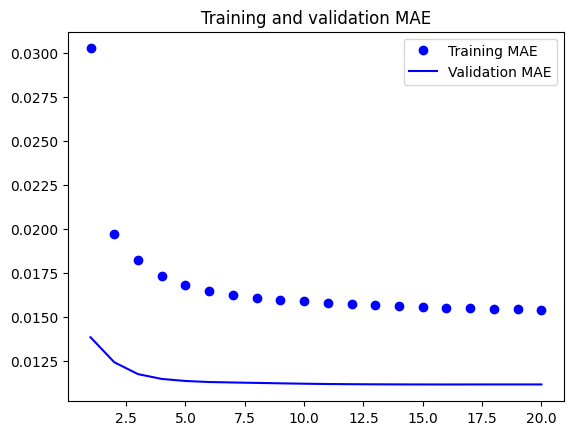

In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, n_features), name="input_layer")
x = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32),
                                  name="bidirectional_rnn_layer")(inputs)
outputs = tf.keras.layers.Dense(1, name="output_layer")(x)
model = tf.keras.Model(inputs, outputs, name="bidirectional_rnn_model")
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset)
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.5f}")

5/5 [==============================] - 0s 13ms/step - loss: 5.7700e-04 - mae: 0.0184
Test MAE: 0.01841


In [ ]:
test_performance['Bidirectional_RNN'] = model.evaluate(test_dataset, verbose=0)[1]
test_performance

{'Baseline': 0.02571843123112198,
 'SimpleRNN': 0.01760908216238022,
 'LSTM': 0.01756584644317627,
 'Stacked_RNN': 0.016931146383285522,
 'Bidirectional_RNN': 0.018413318321108818}

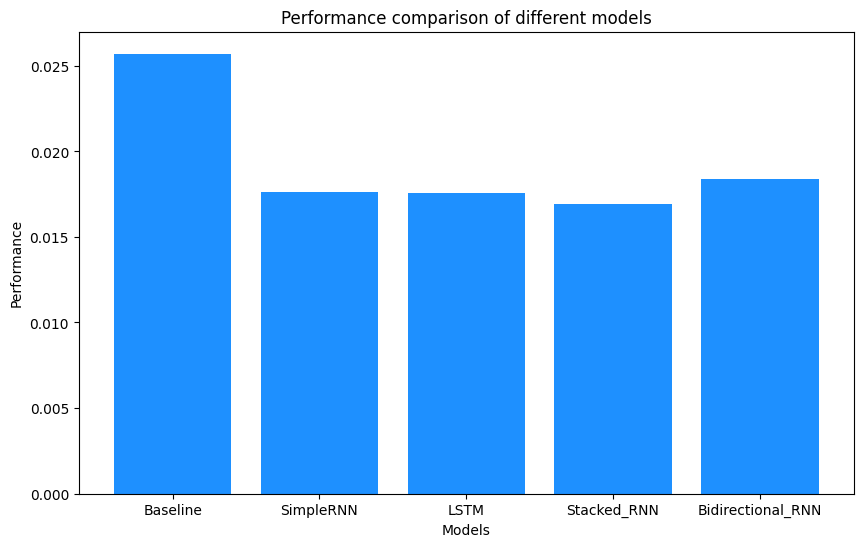

In [ ]:
models = list(test_performance.keys())
values = list(test_performance.values())
plt.figure(figsize=(10, 6))
plt.bar(models, values, color='dodgerblue')
plt.xlabel('Models')
plt.ylabel('Performance')
plt.title('Performance comparison of different models')
plt.show()

In [ ]:
df = raw_frame.copy()
df = df[304:]
df.head()

,AAPL,Log_AAPL,Diff_Log_AAPL
2019-03-04,43.962502,3.783337,0.005017
2019-03-05,43.882500,3.781516,-0.001821
2019-03-06,43.630001,3.775745,-0.005771
2019-03-07,43.125000,3.764103,-0.011642
2019-03-08,43.227501,3.766477,0.002374


In [ ]:
test_period = 100
train_period = len(df) - test_period
print("train_period:", train_period)
print("test_period:", test_period)

train_period: 900
test_period: 100


In [ ]:
train = df.iloc[:train_period]
test  = df.iloc[train_period:]
train_indicator = (df.index <= train.index[-1])
test_indicator =  (df.index > train.index[-1])

In [ ]:
series = df['Diff_Log_AAPL'].dropna().to_numpy()
delta_x = 100 # using the past 100 observations to forecast the next one.
delta_y = 1 # forecasting only one step ahead
X = np.array([series[t:t+delta_x] for t in range(len(series)-delta_x-delta_y+1)]).reshape(-1, delta_x, 1)
Y = np.array([series[t+delta_x+delta_y-1] for t in range(len(series)-delta_x-delta_y+1)]).reshape(-1, delta_y)
N = len(X)
print("X:", X.shape, "Y:", Y.shape, "N:", N)

X: (900, 100, 1) Y: (900, 1) N: 900


In [ ]:
Xtrain, Ytrain = X[:-test_period], Y[:-test_period]
Xtest, Ytest = X[-test_period:], Y[-test_period:]

In [ ]:
n_features = 1
inputs = tf.keras.Input(shape=(delta_x, n_features))
x = tf.keras.layers.LSTM(16)(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(Xtrain, Ytrain, epochs=20, validation_data=(Xtest,Ytest))

Epoch 1/20
25/25 [==============================] - 4s 64ms/step - loss: 5.2474e-04 - mae: 0.0163 - val_loss: 5.2513e-04 - val_mae: 0.0172
Epoch 2/20
25/25 [==============================] - 1s 25ms/step - loss: 4.9011e-04 - mae: 0.0158 - val_loss: 5.4303e-04 - val_mae: 0.0176
Epoch 3/20
25/25 [==============================] - 1s 26ms/step - loss: 4.9780e-04 - mae: 0.0161 - val_loss: 5.2388e-04 - val_mae: 0.0171
Epoch 4/20
25/25 [==============================] - 1s 25ms/step - loss: 4.9253e-04 - mae: 0.0159 - val_loss: 5.2826e-04 - val_mae: 0.0172
Epoch 5/20
25/25 [==============================] - 1s 25ms/step - loss: 4.8420e-04 - mae: 0.0156 - val_loss: 5.2256e-04 - val_mae: 0.0172
Epoch 6/20
25/25 [==============================] - 1s 25ms/step - loss: 4.8031e-04 - mae: 0.0155 - val_loss: 5.4144e-04 - val_mae: 0.0176
Epoch 7/20
25/25 [==============================] - 1s 25ms/step - loss: 4.9230e-04 - mae: 0.0157 - val_loss: 5.3418e-04 - val_mae: 0.0174
Epoch 8/20
25/25 [=========

In [ ]:
train_predictions = model.predict(Xtrain).flatten()
test_predictions = model.predict(Xtest).flatten()

4/4 [==============================] - 0s 8ms/step


In [ ]:
df['Lag_Log_AAPL'] = df['Log_AAPL'].shift(1)
lag = df['Lag_Log_AAPL']

In [ ]:
train_indicator[:delta_x] = False

In [ ]:
df.loc[train_indicator, 'one_step_train'] = lag[train_indicator] + train_predictions
df.loc[test_indicator, 'one_step_test'] = lag[test_indicator] + test_predictions

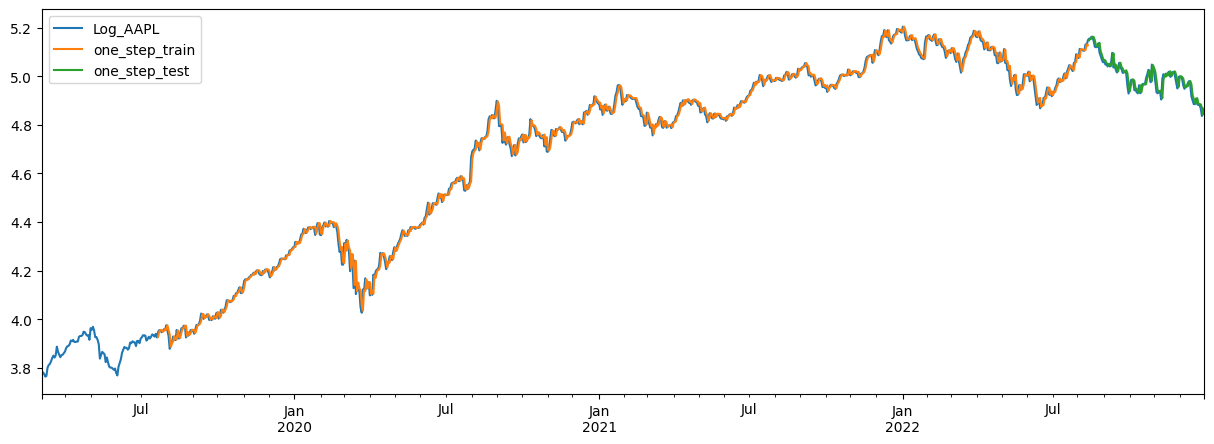

In [ ]:
df[['Log_AAPL', 'one_step_train', 'one_step_test']].plot(figsize=(15, 5));

In [ ]:
multistep_predictions = []
last_x = Xtest[0]
while len(multistep_predictions) < test_period:
  prediction = model.predict(last_x.reshape(1, -1, 1))[0]
  multistep_predictions.append(prediction)
  last_x = np.roll(last_x, -1)
  last_x[-1] = prediction

1/1 [==============================] - 0s 41ms/step


In [ ]:
last_train = train.iloc[-1]['Log_AAPL']

In [ ]:
df.loc[test_indicator, 'multistep_test'] = last_train + np.cumsum(multistep_predictions)

<Axes: >

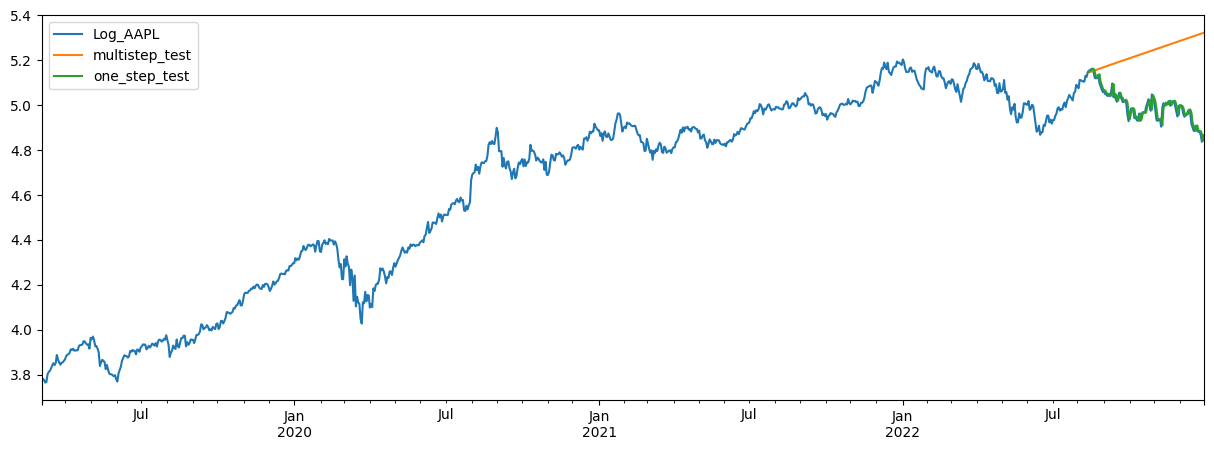

In [ ]:
df[['Log_AAPL', 'multistep_test', 'one_step_test']].plot(figsize=(15, 5))

In [ ]:
delta_x = 100
delta_y = test_period
X = np.array([series[t:t+delta_x] for t in range(len(series)-delta_x-delta_y+1)]).reshape(-1, delta_x, 1)
Y = np.array([series[t+delta_x:t+delta_x+delta_y] for t in range(len(series)-delta_x-delta_y+1)]).reshape(-1, delta_y)
N = len(X)
print("X:", X.shape, "Y:", Y.shape, "N:", N)
Xtrain_multi_out, Ytrain_multi_out = X[:-1], Y[:-1]
Xtest_multi_out, Ytest_multi_out = X[-1:], Y[-1:]
n_features = 1
inputs = tf.keras.Input(shape=(delta_x, n_features))
x = tf.keras.layers.LSTM(16 , return_sequences=True)(inputs)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
# or we could do
# x = layers.LSTM(16 , return_sequences=False)(inputs)
outputs = tf.keras.layers.Dense(delta_y)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(Xtrain_multi_out, Ytrain_multi_out,
                    epochs=20,
                    validation_data=(Xtest_multi_out,Ytest_multi_out)
                    )
train_predictions = model.predict(Xtrain_multi_out)
test_predictions = model.predict(Xtest_multi_out)
train_predictions = train_predictions[:,0]
test_predictions = test_predictions[0]
df.loc[test_indicator, 'multioutput_test'] = last_train + np.cumsum(test_predictions)

X: (801, 100, 1) Y: (801, 100) N: 801
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 16)           1152      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 16)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 100)               1700      
                                                                 
Total params: 2852 (11.14 KB)
Trainable params: 2852 (11.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
25/25 [==============================] - 4

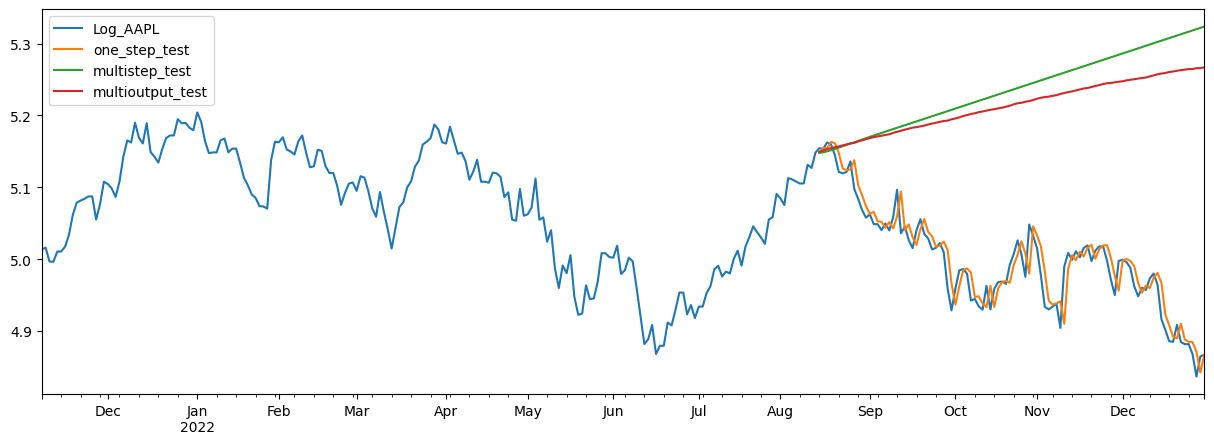

In [ ]:
cols = ['Log_AAPL', 'one_step_test', 'multistep_test',  'multioutput_test']
df.iloc[-300:][cols].plot(figsize=(15, 5));

In [ ]:
test_log_price = df.iloc[-test_period:]['Log_AAPL']
mae1 = mean_absolute_error(test_log_price, df.loc[test_indicator, 'one_step_test'])
mae2 = mean_absolute_error(test_log_price, df.loc[test_indicator, 'multistep_test'])
mae3 = mean_absolute_error(test_log_price, df.loc[test_indicator, 'multioutput_test'])
print("one-step MAE:", mae1)
print("multi-step MAE:", mae2)
print("multi-output MAE:", mae3)

one-step MAE: 0.017909817066998707
multi-step MAE: 0.23885906901638307
multi-output MAE: 0.21623773780147829


In [ ]:
mape1 = mean_absolute_percentage_error(test_log_price, df.loc[test_indicator, 'one_step_test'])
mape2 = mean_absolute_percentage_error(test_log_price, df.loc[test_indicator, 'multistep_test'])
mape3 = mean_absolute_percentage_error(test_log_price, df.loc[test_indicator, 'multioutput_test'])
print("one-step MAE:", mape1)
print("multi-step MAE:", mape2)
print("multi-output MAE:", mape3)

one-step MAE: 0.0035908996692511803
multi-step MAE: 0.04812185710529919
multi-output MAE: 0.04355744535087368


### Univariate Forcasting Plots Using TensorFlow

In [ ]:
df_aapl = df[["AAPL"]]

In [ ]:
df_aapl.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1000 entries, 2019-03-04 to 2022-12-30
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1000 non-null   float64
dtypes: float64(1)
memory usage: 15.6 KB


In [ ]:
column_indices = {name: i for i, name in enumerate(df_aapl.columns)}
n = len(df_aapl)
train_df = df_aapl[0:int(n*0.7)]
val_df = df_aapl[int(n*0.7):int(n*0.9)]
test_df = df_aapl[int(n*0.9):]
num_features = df_aapl.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['AAPL'])
w1

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['AAPL']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


In [ ]:
example_window

<tf.Tensor: shape=(3, 7, 1), dtype=float64, numpy=
array([[[-1.43985741],
        [-1.44208857],
        [-1.44913044],
        [-1.46321431],
        [-1.46035568],
        [-1.41859231],
        [-1.40457813]],

       [[-1.22113972],
        [-1.2098448 ],
        [-1.21103006],
        [-1.22253414],
        [-1.21751415],
        [-1.20398818],
        [-1.21026312]],

       [[-0.80489966],
        [-0.79402305],
        [-0.77805688],
        [-0.77324605],
        [-0.74751864],
        [-0.71467966],
        [-0.71084483]]])>

In [ ]:
example_inputs

<tf.Tensor: shape=(3, 6, 1), dtype=float64, numpy=
array([[[-1.43985741],
        [-1.44208857],
        [-1.44913044],
        [-1.46321431],
        [-1.46035568],
        [-1.41859231]],

       [[-1.22113972],
        [-1.2098448 ],
        [-1.21103006],
        [-1.22253414],
        [-1.21751415],
        [-1.20398818]],

       [[-0.80489966],
        [-0.79402305],
        [-0.77805688],
        [-0.77324605],
        [-0.74751864],
        [-0.71467966]]])>

In [ ]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-1.40457813]],

       [[-1.21026312]],

       [[-0.71084483]]])>

In [ ]:
w1.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='AAPL', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

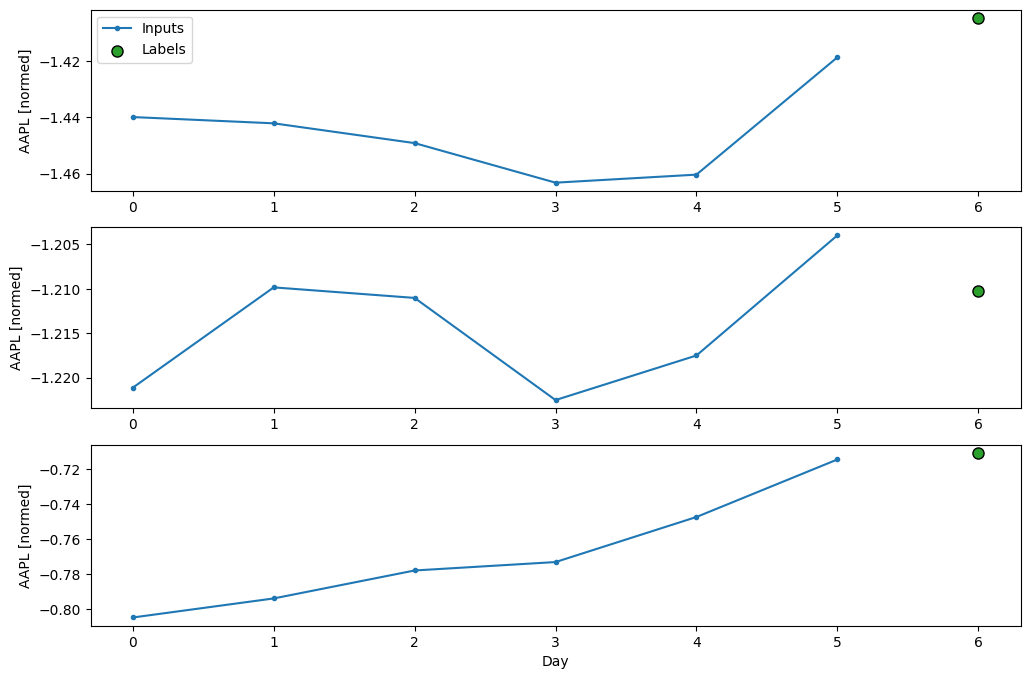

In [ ]:
w1.plot()

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
w1.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['AAPL'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['AAPL']

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
column_indices

{'AAPL': 0}

In [ ]:
baseline = Baseline(label_index=column_indices['AAPL']) # We are selecting the 'AAPL' feature for making the baseline prediction.

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

7/7 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0699


In [ ]:
val_performance

{'Baseline': [0.008165335282683372, 0.06987889856100082]}

In [ ]:
performance

{'Baseline': [0.009180592373013496, 0.07161499559879303]}

In [ ]:
wide_window = WindowGenerator(
    input_width=60, label_width=60, shift=1, # for the baseline model, 1 means we are using yesterday's price as today's forecast.
    label_columns=['AAPL'])

wide_window

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
Label column name(s): ['AAPL']

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 60, 1)
Output shape: (32, 60, 1)


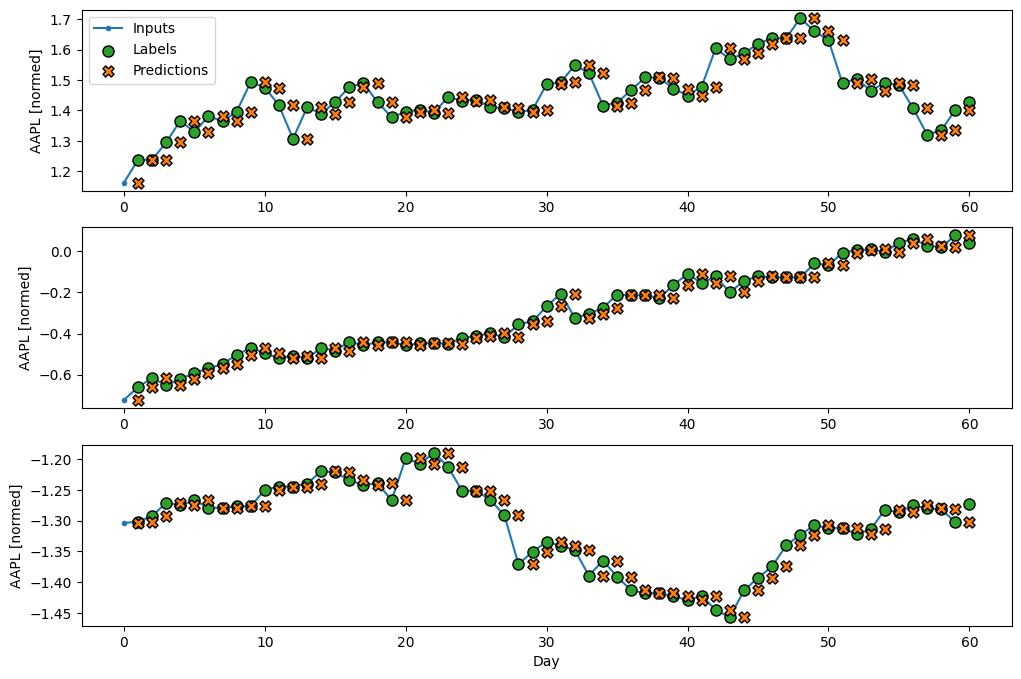

In [ ]:
wide_window.plot(baseline)

In [ ]:
MAX_EPOCHS = 50
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
conv_window = WindowGenerator(
    input_width=60,
    label_width=1,
    shift=1,
    label_columns=['AAPL'])

conv_window

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [60]
Label column name(s): ['AAPL']

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 60, 1)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/50
20/20 [==============================] - 3s 23ms/step - loss: 0.3443 - mean_absolute_error: 0.4393 - val_loss: 0.7086 - val_mean_absolute_error: 0.7728
Epoch 2/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0457 - mean_absolute_error: 0.1614 - val_loss: 0.0954 - val_mean_absolute_error: 0.2621
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0211 - mean_absolute_error: 0.1099 - val_loss: 0.1024 - val_mean_absolute_error: 0.2746
Epoch 4/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0171 - mean_absolute_error: 0.0987 - val_loss: 0.0892 - val_mean_absolute_error: 0.2570
Epoch 5/50
20/20 [==============================] - 0s 11ms/step - loss: 0.0154 - mean_absolute_error: 0.0933 - val_loss: 0.1009 - val_mean_absolute_error: 0.2675
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0954 - mean_absolute_error: 0.2596


In [ ]:
val_performance

{'Baseline': [0.008165335282683372, 0.06987889856100082],
 'Multi step dense': [0.09538929909467697, 0.2596438527107239]}

In [ ]:
performance

{'Baseline': [0.009180592373013496, 0.07161499559879303],
 'Multi step dense': [0.07957781851291656, 0.23630933463573456]}

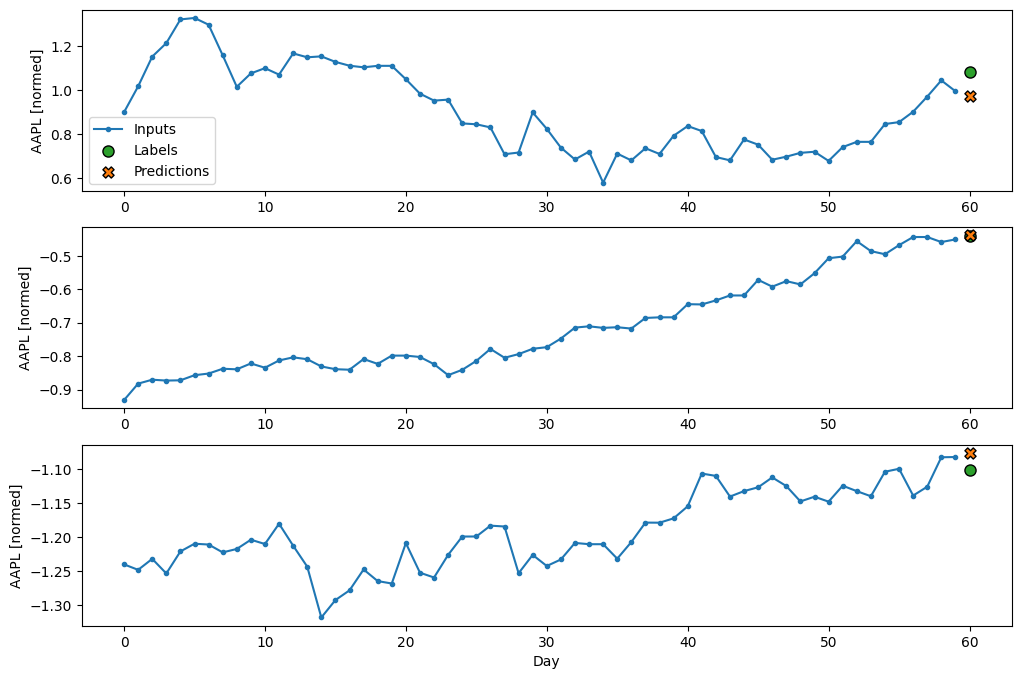

In [ ]:
conv_window.plot(multi_step_dense)

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(60,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 60, 1)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
20/20 [==============================] - 2s 17ms/step - loss: 0.2334 - mean_absolute_error: 0.3696 - val_loss: 0.5148 - val_mean_absolute_error: 0.6475
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0532 - mean_absolute_error: 0.1769 - val_loss: 0.1627 - val_mean_absolute_error: 0.3388
Epoch 3/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0413 - mean_absolute_error: 0.1552 - val_loss: 0.1137 - val_mean_absolute_error: 0.2808
Epoch 4/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0321 - mean_absolute_error: 0.1327 - val_loss: 0.0728 - val_mean_absolute_error: 0.2224
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0259 - mean_absolute_error: 0.1171 - val_loss: 0.0621 - val_mean_absolute_error: 0.2022
Epoch 6/50
20/20 [==============================] - 0s 12ms/step - loss: 0.0220 - mean_absolute_error: 0.1091 - val_loss: 0.0524 - val_mean_absolute_error: 0.1863
Epoch 7/50
20/20 [========

In [ ]:
performance

{'Baseline': [0.009180592373013496, 0.07161499559879303],
 'Multi step dense': [0.07957781851291656, 0.23630933463573456],
 'Conv': [0.040140945464372635, 0.16738376021385193]}

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 60, 1)
Labels shape: (32, 60, 1)
Output shape: (32, 1, 1)


In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 60, 1)
Labels shape: (32, 60, 1)
Output shape: (32, 60, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
20/20 [==============================] - 12s 56ms/step - loss: 0.5925 - mean_absolute_error: 0.6768 - val_loss: 1.5889 - val_mean_absolute_error: 1.2065
Epoch 2/50
20/20 [==============================] - 1s 33ms/step - loss: 0.1167 - mean_absolute_error: 0.2475 - val_loss: 0.3979 - val_mean_absolute_error: 0.5013
Epoch 3/50
20/20 [==============================] - 1s 30ms/step - loss: 0.0649 - mean_absolute_error: 0.1637 - val_loss: 0.4029 - val_mean_absolute_error: 0.5154
Epoch 4/50
20/20 [==============================] - 1s 30ms/step - loss: 0.0533 - mean_absolute_error: 0.1394 - val_loss: 0.3322 - val_mean_absolute_error: 0.4511
Epoch 5/50
20/20 [==============================] - 1s 30ms/step - loss: 0.0471 - mean_absolute_error: 0.1268 - val_loss: 0.2840 - val_mean_absolute_error: 0.4024
Epoch 6/50
20/20 [==============================] - 1s 30ms/step - loss: 0.0424 - mean_absolute_error: 0.1181 - val_loss: 0.2425 - val_mean_absolute_error: 0.3548
Epoch 7/50
20/20 [===

In [ ]:
performance

{'Baseline': [0.009180592373013496, 0.07161499559879303],
 'Multi step dense': [0.07957781851291656, 0.23630933463573456],
 'Conv': [0.040140945464372635, 0.16738376021385193],
 'LSTM': [0.027021992951631546, 0.1008535847067833]}

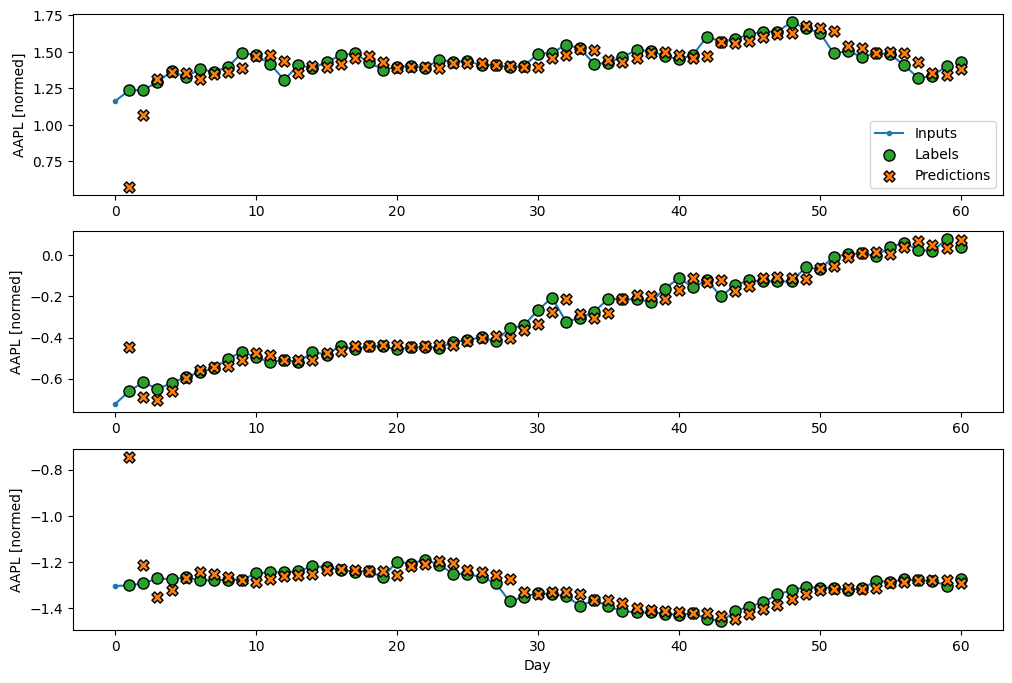

In [ ]:
wide_window.plot(lstm_model)

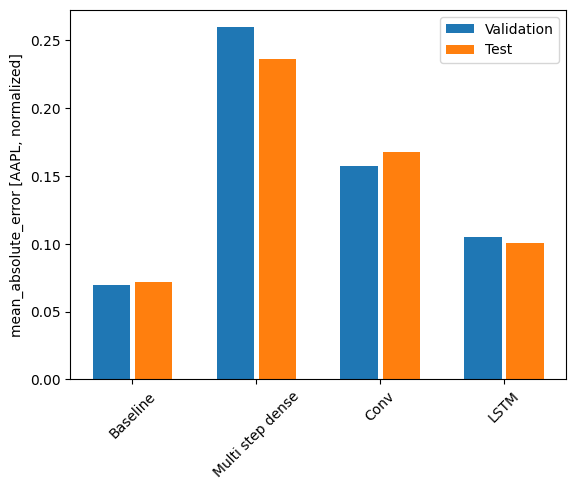

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [AAPL, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

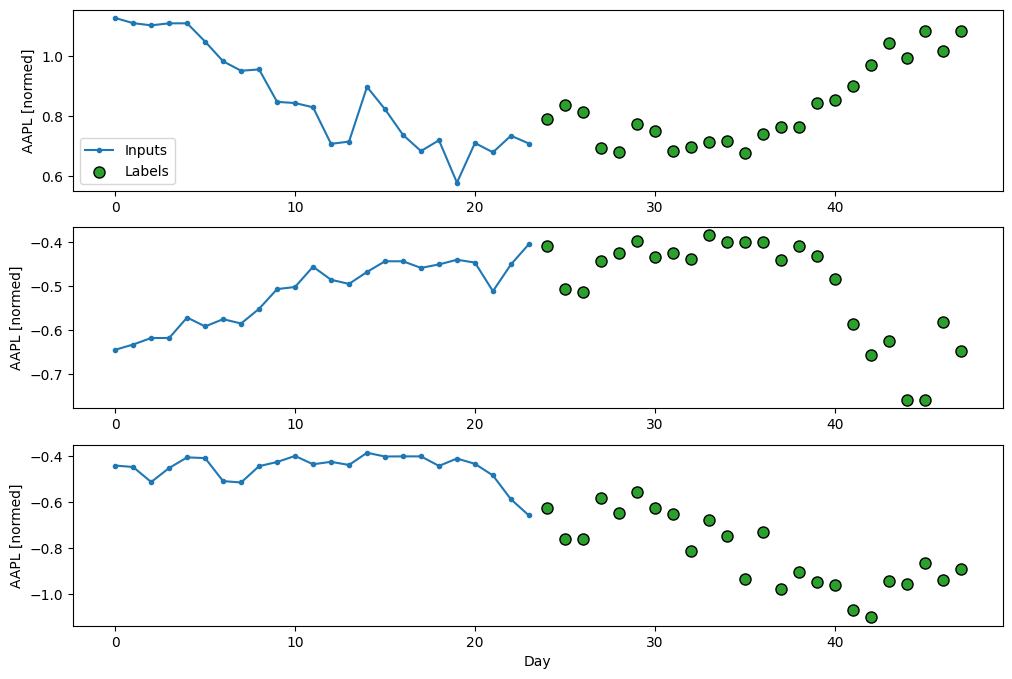

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

5/5 [==============================] - 1s 4ms/step - loss: 0.0861 - mean_absolute_error: 0.2374


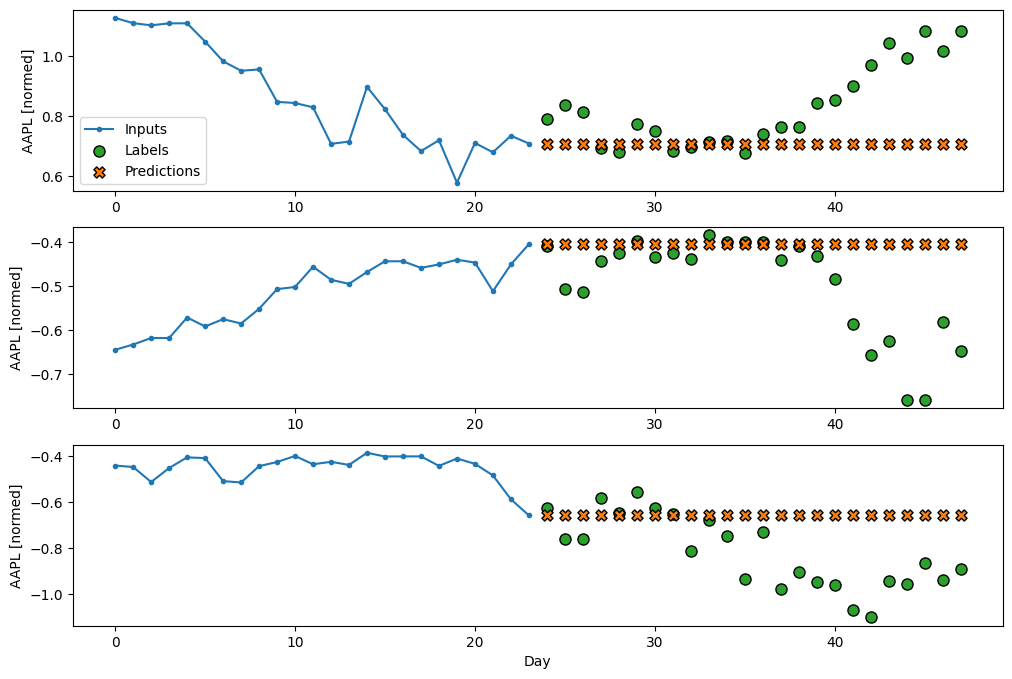

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Epoch 1/50
21/21 [==============================] - 4s 39ms/step - loss: 0.8290 - mean_absolute_error: 0.8345 - val_loss: 2.4657 - val_mean_absolute_error: 1.5272
Epoch 2/50
21/21 [==============================] - 0s 16ms/step - loss: 0.3857 - mean_absolute_error: 0.5329 - val_loss: 1.3182 - val_mean_absolute_error: 1.0862
Epoch 3/50
21/21 [==============================] - 0s 17ms/step - loss: 0.1364 - mean_absolute_error: 0.3072 - val_loss: 0.6904 - val_mean_absolute_error: 0.7442
Epoch 4/50
21/21 [==============================] - 0s 16ms/step - loss: 0.1041 - mean_absolute_error: 0.2763 - val_loss: 0.7514 - val_mean_absolute_error: 0.7842
Epoch 5/50
5/5 [==============================] - 0s 6ms/step - loss: 0.7195 - mean_absolute_error: 0.7664


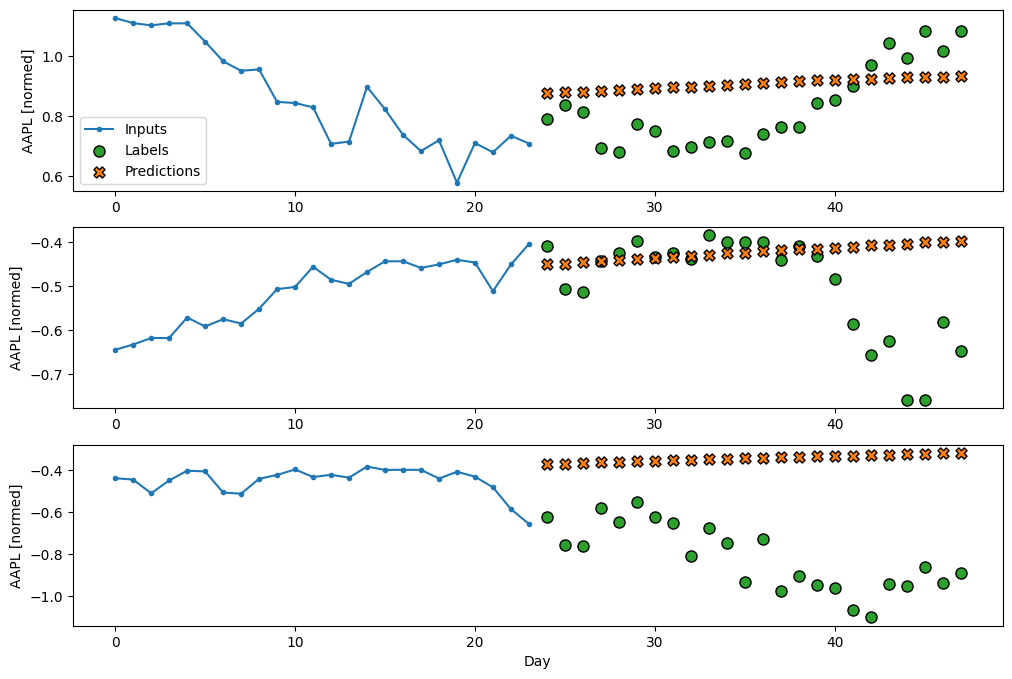

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)


multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 1)


Epoch 1/50
21/21 [==============================] - 8s 76ms/step - loss: 0.0522 - mean_absolute_error: 0.1812 - val_loss: 0.4417 - val_mean_absolute_error: 0.5833
Epoch 2/50
21/21 [==============================] - 0s 21ms/step - loss: 0.0429 - mean_absolute_error: 0.1606 - val_loss: 0.3042 - val_mean_absolute_error: 0.4732
Epoch 3/50
21/21 [==============================] - 0s 20ms/step - loss: 0.0385 - mean_absolute_error: 0.1503 - val_loss: 0.1560 - val_mean_absolute_error: 0.3341
Epoch 4/50
21/21 [==============================] - 0s 20ms/step - loss: 0.0357 - mean_absolute_error: 0.1405 - val_loss: 0.1672 - val_mean_absolute_error: 0.3447
Epoch 5/50
5/5 [==============================] - 0s 6ms/step - loss: 0.1666 - mean_absolute_error: 0.3427


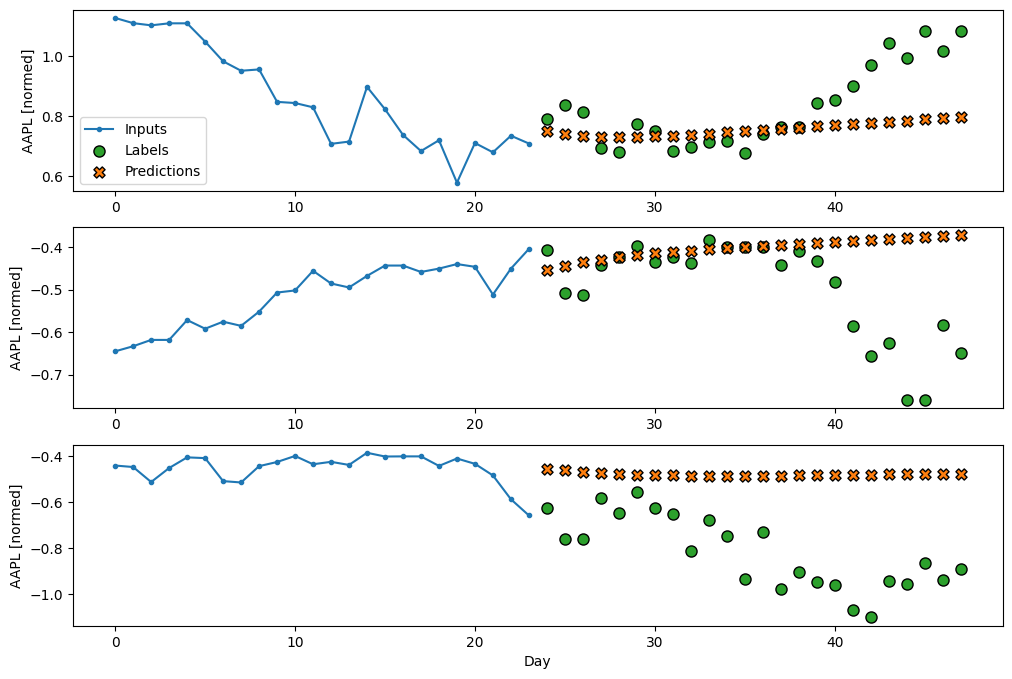

In [ ]:
history = compile_and_fit(feedback_model, multi_window)
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

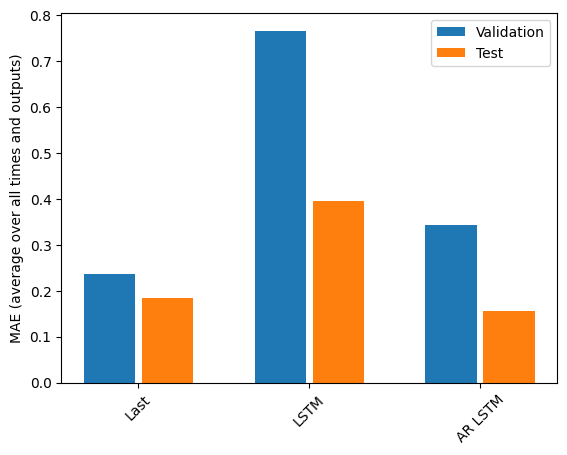

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

### Deep Sequence Model Using LSTM

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
fname = os.path.join("drive", "MyDrive", "jena_climate","jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))
print(lines[0:1])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30']


In [ ]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

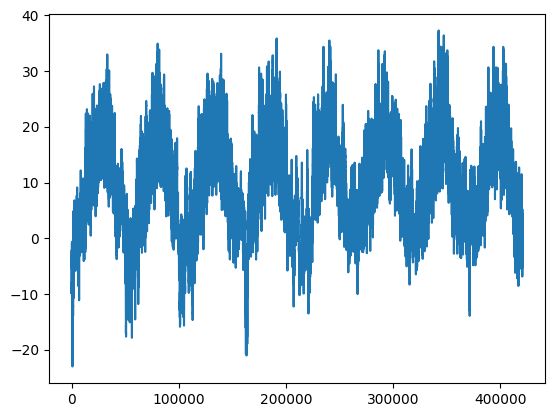

In [ ]:
plt.plot(range(len(temperature)), temperature)
plt.show()

In [ ]:
temperature

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

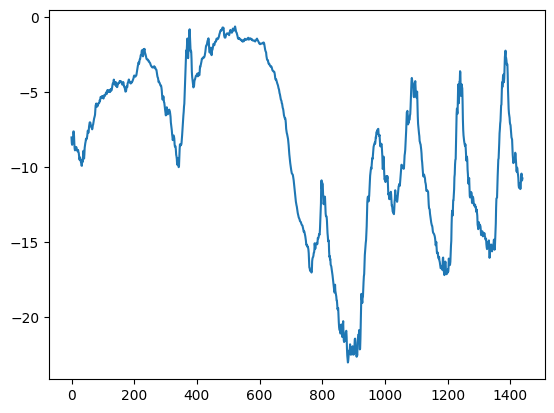

In [ ]:
plt.plot(range(1440), temperature[:1440])
plt.show()

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(16, activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/3
819/819 [==============================] - 59s 70ms/step - loss: 13.7094 - mae: 2.8744 - val_loss: 11.9221 - val_mae: 2.7436
Epoch 2/3
819/819 [==============================] - 55s 67ms/step - loss: 9.8661 - mae: 2.4679 - val_loss: 14.9412 - val_mae: 3.0794
Epoch 3/3
819/819 [==============================] - 51s 62ms/step - loss: 8.9420 - mae: 2.3507 - val_loss: 10.4727 - val_mae: 2.5527


OSError: ignored

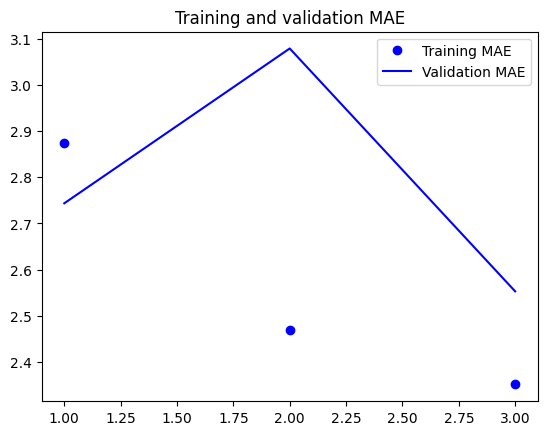

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.Conv1D(8, 24, activation="relu")(inputs)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Conv1D(8, 12, activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Conv1D(8, 6, activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/2
819/819 [==============================] - 127s 151ms/step - loss: 23.5339 - mae: 3.8026 - val_loss: 17.1468 - val_mae: 3.2275
Epoch 2/2
405/405 [==============================] - 19s 47ms/step - loss: 16.9001 - mae: 3.2722
Test MAE: 3.27


In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.LSTM(16)(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset)

In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = tf.keras.layers.GRU(32, recurrent_dropout=0.5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")